In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary 



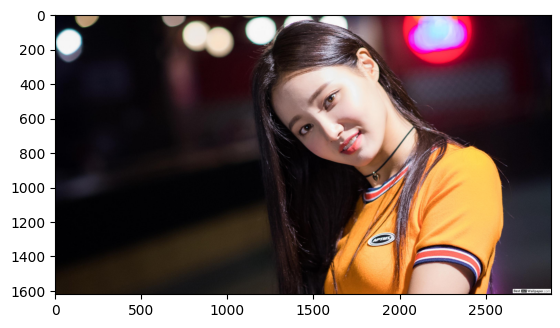

In [3]:
# image
img = Image.open('./연우3.jpg')
fig = plt.figure()
plt.imshow(img)


In [4]:
# resize to a imagenet size
transform = Compose([Resize((224,224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0)
x.shape

torch.Size([1, 3, 224, 224])

# Patches Embeddings

In [5]:
# patch로 나누기
patch_size = 16
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
# ()안에 있는 수는 곱해져 있음 (h w) = 1channel에서 패치의 개수 = 논문에서 N , (s1 s2 c) = 패치의 차원 크기 = 논문에서 P^2 * C


#### Patch 나누기 + Projection
- 1. Linear Projection
- 2. Linear projection 대신에 Conv Layer를 사용하여 성능을 높임

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int = 3, patch_size:int = 16, emb_size:int =768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

In [7]:
x.shape

torch.Size([1, 3, 224, 224])

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int = 3, patch_size:int = 16, emb_size:int =768):
        self.patch_size = patch_size
        super().__init__()
        # out_channels = emb_size
        # b =1 , e = emb_size= output_size = kernel 개수, W,H =  (224- patch_size)/patch_size + 1 = 224/patch_size 
        # emb_size = output 채널 수 
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride = patch_size), 
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

#### CLS Token
- CLS Token = sequence에 따라 붙는 숫자

In [9]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int = 3, patch_size:int = 16, emb_size:int =768):
        self.patch_size = patch_size
        super().__init__()
        # out_channels = emb_size
        # b =1 , e = emb_size= output_size = kernel 개수, W,H =  (224- patch_size)/patch_size + 1 = 224/patch_size 
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride = patch_size), 
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens= repeat(self.cls_token, '() n e -> b n e', b=b) # batch 수 만큼 복제
        x = torch.cat([cls_tokens, x], dim=1) # x:(b, (h w) , e), cls_token: (1,1,e)
        return x
        
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

#### Position Embedding

In [10]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int = 3, patch_size:int = 16, emb_size:int =768, img_size:int = 224):
        self.patch_size = patch_size
        super().__init__()
        # out_channels = emb_size
        # b =1 , e = emb_size= output_size = kernel 개수, W,H =  (224- patch_size)/patch_size + 1 = 224/patch_size 
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride = patch_size), 
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size)) # 랜덤 초기화됨
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size)) # x의 차원에 맞게 랜덤 초기화( h*w + 1 , e)
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens= repeat(self.cls_token, '() n e -> b n e', b=b) # batch 수 만큼 복제, 각 batch의 맨 앞에 붙어서 sequence의 첫번째 임을 알려줌
        x = torch.cat([cls_tokens, x], dim=1) # x:(b, (h w) , e), cls_token: (1,1,e)  ## 순서가 x 앞에 붙는게 중요함 
        # position embedding을 추가
        x += self.positions
        return x
        
    
PatchEmbedding()(x).shape
# (b, (h w) + 1, e)

torch.Size([1, 197, 768])

## Transformer

### Attention


In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int=768, num_heads:int =8, dropout:float=0. ):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        self.scaling = (self.emb_size // num_heads) ** -0.5 # root(d_k) 만큼 나눠 스케일링, d_k = query size 
        
    def forward(self, x:Tensor, mask:Tensor=None) -> Tensor:
        queries = rearrange(self.queries(x), 'b n (h d) -> b h n d', h=self.num_heads) # b: batch_size, n : 자연어에서는 sequence, 지금은 vision이라서 patch 개수  , (h d) : embedding size , h: num of heads , d: query size
        keys = rearrange(self.keys(x), 'b n (h d) -> b h n d', h=self.num_heads)
        values = rearrange(self.values(x), 'b n (h d) -> b h n d', h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # query, key의 행렬곱 , batch크기와 head개수를 제외하고 n(Sequence Length) d(Query Size) 끼리만 곱함  
        if mask is not None: #? 
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        
        att = F.softmax(energy, dim=-1) * self.scaling
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values) # attention 값과 value 곱해줌 
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
        
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape
        

torch.Size([1, 197, 768])

- 행렬로 처리하는 다른 ver. 나중에 읽어보기 
  

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0.):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

### Residuals


In [13]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

### MLP
- nn.Sequential을 상속받아 forward 메서드를 작성하지 않아도 됨


In [14]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size:int, expansion:int = 4, drop_p :float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size)   
        )
        

In [15]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p : float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p : float = 0.,
                 **kwargs):
        ## kwargs = num_heads, dropout을 딕셔너리 형태로 넣어서 바꿀 수 있음.
        # 결국 TransformerEncoder -> TransformerEncoderBlock -> LayerNorm -> MultiHeadAttention 순으로 들어가서 모든 클래스에 kwargs 인자값을 넣어줘야함
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),  
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size,expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )),
        )


In [16]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

### Transformer
- ViT에서는 Transformer의 Encoder 부분만 들어감
- 12개 쌓는다고 구현

In [17]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth:int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

### Head
- 전체 Sequence( = patch 개수)에 대한 평균을 구함

In [18]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [19]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        

In [20]:
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19

In [25]:
ViT()(x)

tensor([[-4.7295e-01, -1.5537e+00,  6.3572e-01,  8.0302e-01,  4.1550e-01,
          5.3757e-01, -6.9081e-01,  2.2139e-01, -7.9817e-01, -6.5404e-01,
          3.8511e-01, -5.8629e-01,  1.8223e+00, -1.5835e-01,  3.2957e-01,
          2.3146e-01, -1.8132e-01, -3.5801e-01,  1.5484e-01, -1.2378e-02,
         -2.7864e-01, -3.1510e-01, -3.9123e-01,  1.2168e-01, -3.5759e-01,
          4.0210e-01, -7.8956e-02, -8.4541e-01,  4.6695e-01, -4.4116e-01,
         -3.3840e-01, -4.6007e-01,  2.4632e-01, -1.1506e+00, -1.7035e-01,
         -4.6376e-01, -3.3137e-01, -4.7409e-01,  2.7591e-02, -1.0973e-01,
          1.4410e+00, -4.6029e-01, -7.7821e-02,  1.6771e-01,  1.0769e+00,
          4.9984e-01, -1.5908e-01,  2.5034e-01, -1.5075e-01, -5.8903e-01,
         -1.3499e+00, -7.8240e-01,  6.9122e-02, -1.2891e+00, -1.3999e-01,
          2.9317e-01, -4.8304e-01,  6.2156e-01,  1.4856e-01,  3.5535e-01,
         -3.5993e-01, -6.3053e-02, -1.6885e+00,  6.1109e-01, -7.0688e-01,
          4.9947e-01, -1.1305e+00, -2.